# CV task

В данной задаче обучена нейронная сеть, осуществляющая сегментацию границ клеток на изображении. Оптимизируемая метрика - intersection-over-union (IoU), реализация данной метрики приведена в коде ниже.

In [0]:
### Download the dataset ###
!wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
!unzip -q data.zip

## Количество изображений в трейне/валидации/тесте:

In [3]:
import os
print("Images on train", len(os.listdir('BBBC018_v1_images-fixed/train')))
print("Images on val", len(os.listdir('BBBC018_v1_images-fixed/val')))
print("Images on test", len(os.listdir('BBBC018_v1_images-fixed/test')))

Images on train 41
Images on val 7
Images on test 7


Видим, что выборка очень небольшая, поэтому при обучении сети будем использовать различные аугментации.

## Выборочная визуализация данных

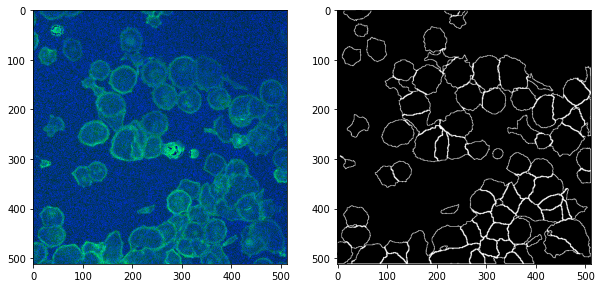

In [4]:
### Visualize the data ###
import matplotlib.pyplot as plt
import numpy as np
import skimage
from skimage import io
%matplotlib inline

# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = skimage.img_as_ubyte(io.imread('BBBC018_v1_images-fixed/train/00736-actin.DIB.bmp'))
plt.imshow(im)
plt.subplot(1,2,2)
mask = skimage.img_as_ubyte(io.imread('BBBC018_v1_outlines/train/00736-cells.png'))
plt.imshow(mask, 'gray')

## Целевая метрика

In [0]:
### Target metric ###
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

## Обучение нейросети

In [0]:
from albumentations import (
    PadIfNeeded,
    HorizontalFlip,
    VerticalFlip,    
    CenterCrop,    
    Crop,
    Compose,
    Transpose,
    RandomRotate90,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    RandomSizedCrop,
    OneOf,
    CLAHE,
    RandomBrightnessContrast,    
    RandomGamma    
)

In [0]:
from IPython.display import clear_output
import os

import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, utils
from torch.autograd import Variable


from torch.nn import Conv2d as Conv2D
import torch.nn.init as init

from torch.nn import Upsample

In [0]:
#https://github.com/mateuszbuda/brain-segmentation-pytorch/
from collections import OrderedDict

import torch
import torch.nn as nn

class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=16):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=8, out_channels=out_channels, kernel_size=1
        )
        self.conv_last = nn.Conv2d(features, 8, kernel_size = 3, padding=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        dec1 = self.conv_last(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [0]:
class SegmentationDataset(Dataset):
    def __init__(self, root_dir_img, root_dir_mask, transform):
        super(SegmentationDataset).__init__()
        self.root_dir_img = root_dir_img
        self.root_dir_mask = root_dir_mask
        
        self.files_img = sorted(os.listdir(self.root_dir_img))
        self.files_mask = sorted(os.listdir(self.root_dir_mask))
      
        self.aug = transform
        self.ToTensor = transforms.ToTensor() 
        self.final_transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5,0.5,0.5),(1.,1.,1.))])
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir_img,
                                self.files_img[idx])
        mask_name = os.path.join(self.root_dir_mask,
                                self.files_mask[idx])
      
        img = cv2.imread(img_name)
        mask_ = cv2.imread(mask_name, 0)
        
        if self.aug != None:
            augmented =  self.aug(image=img, mask=mask_)
            return (self.final_transform(augmented['image']), 
                    self.ToTensor(augmented['mask']))
        
        return self.final_transform(img), self.ToTensor(mask_)

    def __len__(self):
        return len(self.files_img)

In [0]:
aug = Compose([
    VerticalFlip(p=0.5),              
    RandomRotate90(p=0.5),
    OneOf([
        ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
        GridDistortion(p=0.5) ], p=0.8),
    CLAHE(p=0.8),
    RandomBrightnessContrast(p=0.5),    
    RandomGamma(p=0.5)])

In [0]:
transform_val = transforms.Compose([transforms.ToTensor()])

train_data = SegmentationDataset('./BBBC018_v1_images-fixed/train', 
                                 './BBBC018_v1_outlines/train', 
                                 aug)

val_data = SegmentationDataset('./BBBC018_v1_images-fixed/val', 
                               './BBBC018_v1_outlines/val', 
                               None)

train_loader = DataLoader(train_data, batch_size=1,shuffle=True)
val_loader = DataLoader(val_data, batch_size=1)

In [0]:
model = UNet(3,1)
_ = model.cuda()

In [0]:
criterion = nn.BCELoss()

train_losses = []
val_losses = []

train_metrics = []
val_metrics = []

hist = {"train_loss": [],
        "train_iou": [],
        "val_loss": [],
        "val_iou": []}

In [0]:
lr = 1e-4
optimizer = optim.RMSprop(model.parameters(), lr)
num_epochs = 30

In [0]:
from tqdm import trange

 97%|█████████▋| 29/30 [02:12<00:04,  4.53s/it]

Epoch 29/30	 Loss mean: 0.103136	 IoU mean: 0.216238
Epoch 29/30	 Val Loss mean: 0.145163	 Val IoU mean: 0.240465


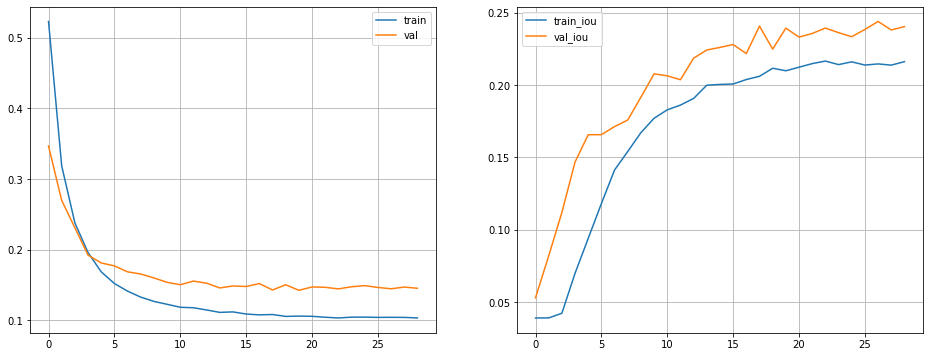

Epoch: 30 	Loss: 0.031487
Epoch: 30 	Loss: 0.075909
Epoch: 30 	Loss: 0.060452
Epoch: 30 	Loss: 0.039343
Epoch: 30 	Loss: 0.134824
Epoch: 30 	Loss: 0.108448
Epoch: 30 	Loss: 0.097789
Epoch: 30 	Loss: 0.225636


100%|██████████| 30/30 [02:17<00:00,  4.58s/it]

Epoch: 30 	Loss: 0.155658
CPU times: user 2min 10s, sys: 17.5 s, total: 2min 27s
Wall time: 2min 17s


In [16]:
%%time

for i in trange(num_epochs):
    if (i == 20):
        lr = 1e-5
        optimizer = optim.RMSprop(model.parameters(), lr)
    if i>0:
         print("Epoch %d/%d\t Loss mean: %f\t IoU mean: %f"% \
               (i, num_epochs, epoch_loss, epoch_iou))
         print("Epoch %d/%d\t Val Loss mean: %f\t Val IoU mean: %f"% \
               (i, num_epochs, val_loss, val_iou))
    
         plt.figure(figsize=(16, 6))
         plt.subplot(121)
         plt.plot(hist['train_loss'], label='train')
         plt.plot(hist['val_loss'], label='val')
         plt.legend()
         plt.grid()
        
         plt.subplot(122)
         plt.plot(hist['train_iou'], label='train_iou')
         plt.plot(hist['val_iou'], label='val_iou')
         plt.legend()
         plt.grid()
         plt.show()

    epoch_losses = []
    epoch_ious = []
    val_losses = []
    val_ious = []
    
    model.train()
    for k, (img, mask) in enumerate(train_loader):  
        optimizer.zero_grad()
        y_pred = model(img.cuda())
        loss = criterion(y_pred, mask.cuda())
        
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        iou = calc_iou(y_pred.cpu().detach().numpy()>0.1, 
                                  mask.numpy())
        epoch_ious.append(iou)
        
        
        if k%5 == 0:
            print("Epoch: %d \tLoss: %f"%(i+1, loss.item()))
    
    epoch_loss = np.mean(np.array(epoch_losses))
    epoch_iou = np.mean(np.array(epoch_ious))
    hist['train_iou'].append(epoch_iou)
    hist['train_loss'].append(epoch_loss)
    with torch.no_grad():
        model.eval()
        for k, (img, mask) in enumerate(val_loader):
            y_pred = model(img.cuda())
            loss = criterion(y_pred, mask.cuda())
            iou = calc_iou(y_pred.cpu().detach().numpy()>0.15, 
                                  mask.numpy())
            val_losses.append(loss.item())
            val_ious.append(iou)
            
            
            
    val_loss = np.mean(np.array(val_losses))
    val_iou = np.mean(np.array(val_ious))
    hist['val_loss'].append(val_loss)
    hist['val_iou'].append(val_iou)
    if i < (num_epochs - 1):
        clear_output()
    

In [0]:
torch.save(model.state_dict(), "weights.h5f")

In [17]:
with torch.no_grad():
    model.eval()
    val_ious = []
    for k, (img, mask) in enumerate(val_loader):
        y_pred = model(img.cuda())
        loss = criterion(y_pred, mask.cuda())
        
        iou = calc_iou(y_pred.cpu().detach().numpy()>0.16, 
                                  mask.numpy())
        val_ious.append(iou)
            
    
    val_iou = np.mean(np.array(val_ious))
    
    print("IoU on Val set: %.3f" % val_iou)

IoU on Val set: 0.242


In [18]:
from PIL import Image
test_path = "./BBBC018_v1_images-fixed/test/"
test_files = sorted(os.listdir(test_path))

convert_to_img = transforms.ToPILImage()
convert_to_tensor = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5,0.5,0.5),(1.,1.,1.))])
with torch.no_grad():
    model.eval()
    for img_path in test_files:
        print(img_path)
        path_to_pic = os.path.join(test_path, img_path)
        pic = Image.open(path_to_pic)
        X = convert_to_tensor(pic).unsqueeze(0)
        y = (model(X.cuda()).detach().cpu()>0.15)[0]*1.
        pic_out = convert_to_img(y)
        pic_out.save(img_path[:-4]+".png")

00733-actin.DIB.bmp
05624-actin.DIB.bmp
05899-actin.DIB.bmp
10780-actin.DIB.bmp
13361-actin.DIB.bmp
13569-actin.DIB.bmp
19466-actin.DIB.bmp
